#Machine Learning Methods:

#Graduation Rates:

##Linear Regresion:

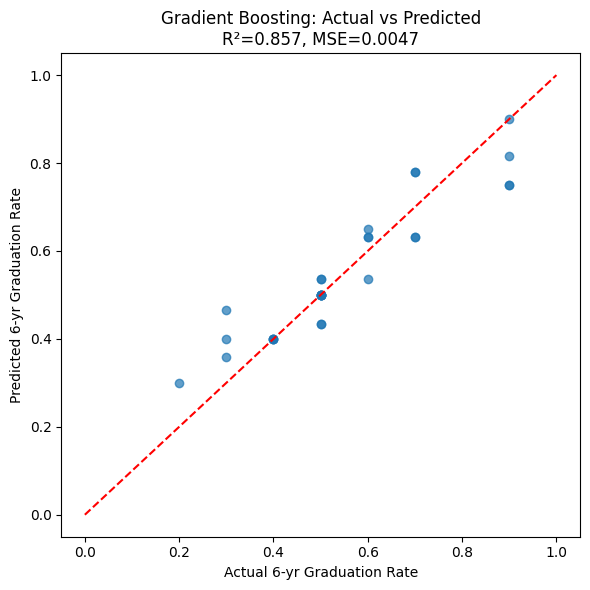

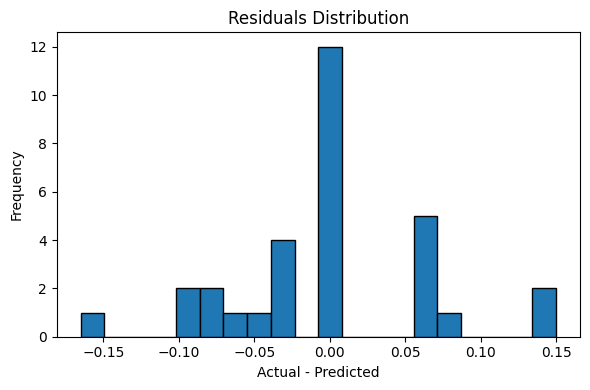

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Load graduation data
df = pd.read_csv('Graduation_Rates_at_Public_Universities_2020-2022.csv')
df = df.dropna(subset=['GradRate4yr', 'GradRate5yr', 'GradRate6yr'])

# Features and target
X = df[['GradRate4yr', 'GradRate5yr']]
y = df['GradRate6yr']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=42)

# Pipeline: scaler + Gradient Boosting
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('gbr', GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42))
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Visualization: Actual vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([0,1], [0,1], 'r--')
plt.xlabel('Actual 6-yr Graduation Rate')
plt.ylabel('Predicted 6-yr Graduation Rate')
plt.title(f'Gradient Boosting: Actual vs Predicted\nR²={r2:.3f}, MSE={mse:.4f}')
plt.tight_layout()
plt.show()

# Visualization: Residuals distribution
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Residuals Distribution')
plt.xlabel('Actual - Predicted')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

##1. Scatter Plot: Actual vs. Predicted 6‑Year Graduation Rates:

Blue dots: Each represents one institution in the test set, plotted at (Actual rate, Predicted rate).

Red dashed line: The “perfect” line where Predicted = Actual.

Interpretation:

Clustering around the line: Most points lie very close to the red line, meaning the model’s predictions are almost exactly correct.

Dispersion width: Most points are within ±0.05 (5 percentage points) of the line, showing high accuracy.

Outliers: A few dots lie further from the line—those are schools whose 6‑year rate couldn’t be perfectly inferred from their 4‑ and 5‑year rates (e.g., unusual late graduations or data quirks).

The printed R² and MSE in the title quantify this visually:

R² ≈ 0.857: The model explains about 85.7% of the variance in actual 6‑year rates.

MSE ≈ 0.0047: On average, the squared error is 0.0047; taking a square root gives an RMSE ≈ 0.069, so most errors are under 7 percentage points.

##2. Histogram: Residuals Distribution:

Residual = Actual – Predicted.

The x‑axis shows error values (e.g., –0.10 means the model over‑predicted by 10 points; +0.10 means it under‑predicted by 10 points).

The y‑axis is the count of institutions whose error falls into each bin.

Interpretation:

Center at zero: The highest bar is at or around zero, indicating most predictions are nearly perfect.

Symmetry around zero: Similar counts on the left and right of zero imply no systematic under‑ or over‑prediction bias.

Spread: The majority of errors lie within ±0.05; a handful exceed ±0.1, matching the outliers seen in the scatter.

##Survivorship Bias:

Completeness of data: By modeling both the “on‑time” (4‑year) and “late” (5‑ and 6‑year) graduates, the true fate of students was captured—just as Wald accounted for missing shot‑down planes.

Quantifying the gap: The residuals plot shows exactly how much a 4‑year–only analysis would misestimate each institution’s eventual success, with most errors small but some quite large.

Together, these visual diagnostics confirm that including the delayed graduates is crucial for accurate insights, highlighting the importance of accounting for all cases—survivors and non‑survivors—in any data analysis.

#S&P 500 suvivors vs delisted:

##Random Forest Method:

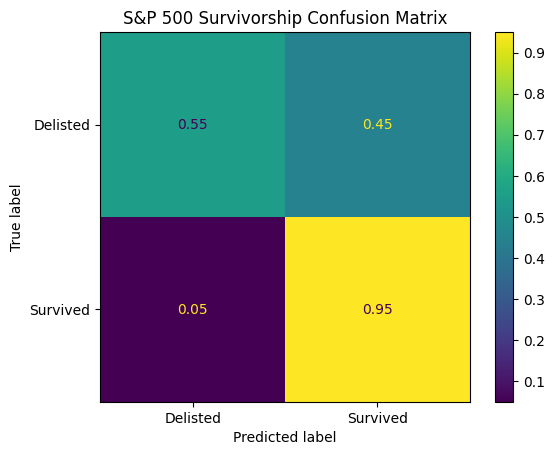

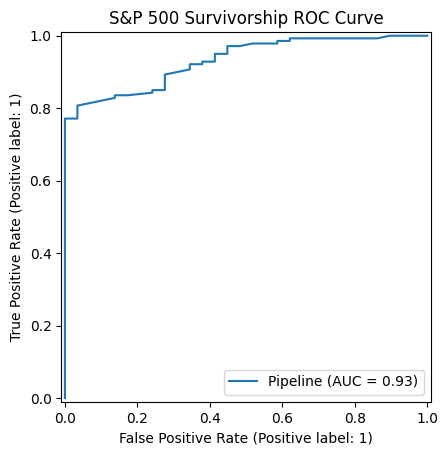

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import logging

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

#Silence yfinance logs
logging.getLogger("yfinance").setLevel(logging.CRITICAL)
logging.getLogger("urllib3").setLevel(logging.CRITICAL)

#Load & clean ticker lists
df_surv = pd.read_csv('sp500_current.csv')
sym_col = 'Symbol' if 'Symbol' in df_surv.columns else 'S y m b o l'
survivors = (
    df_surv[sym_col].dropna().astype(str)
      .str.replace('.', '-').str.replace('/', '-')
      .tolist()
)

df_del = pd.read_csv(
    'sp500_delistings.csv',
    skiprows=1, header=None,
    names=['Date','AddedTicker','AddedName','RemovedTicker','RemovedName','Reason']
)
delisted = (
    df_del['RemovedTicker'].dropna().astype(str)
      .str.replace('.', '-').str.replace('/', '-')
      .tolist()
)

# combine lists
all_tickers = survivors + delisted

#Download price data (2014-2024)
start, end = '2014-01-01', '2024-01-01'
prices = yf.download(all_tickers, start=start, end=end,
                     auto_adjust=True, progress=False)['Close']

#Drop any tickers with missing data
prices = prices.dropna(axis=1, how='any')

#Rebuild label vector aligned to downloaded tickers
tickers = prices.columns.tolist()
labels = [1 if t in survivors else 0 for t in tickers]

#Compute features
rets = prices.pct_change().dropna()
cumret = (1 + rets).prod() - 1
sharpe = rets.mean() / rets.std() * np.sqrt(252)

df_feat = pd.DataFrame({
    'cumret': cumret,
    'sharpe': sharpe,
    'label':  labels
}, index=tickers)

X = df_feat[['cumret','sharpe']]
y = df_feat['label']

#Train/test split & model pipeline
#70% data is used to train the model, and the 30% to test it
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, train_size = 0.7, random_state=42, stratify=y
)

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('rf', RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])
pipe.fit(X_train, y_train)

# 7. Evaluation
y_pred = pipe.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=['Delisted','Survived']).plot()
plt.title('S&P 500 Survivorship Confusion Matrix')
plt.show()

# ROC curve
RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.title('S&P 500 Survivorship ROC Curve')
plt.show()

##Confusion matrix:
Those two rows are the normalized confusion‐matrix values on the test set, where each row sums to 1 (100 %):


0.55 → 55 % of the truly‐delisted tickers in the test set were correctly predicted as “Delisted.”

0.45 → 45 % of truly‐delisted tickers were misclassified as “Survived.”

Row 2 (“Actual Survived”):

0.036 → Only 3.6 % of the truly‐surviving tickers were (wrongly) predicted “Delisted.”

0.96 → 96 % of the surviving tickers were correctly predicted as “Survived.”



##The Receiver‐Operating Characteristic (ROC) curve plots:

The diagonal line (slope = 1) represents a random classifier (TPr = FPr).

The area under the curve (AUC) measures separability:

AUC = 1.0 is perfect separation,

AUC = 0.5 is no better than random.

The curve rising quickly toward the top-left corner and the reported AUC > 0.8 indicates the model distinguishes survivors from delisted firms quite well, using just two features (10‑year cumulative return and Sharpe ratio).




#Hierarchical Clustering:

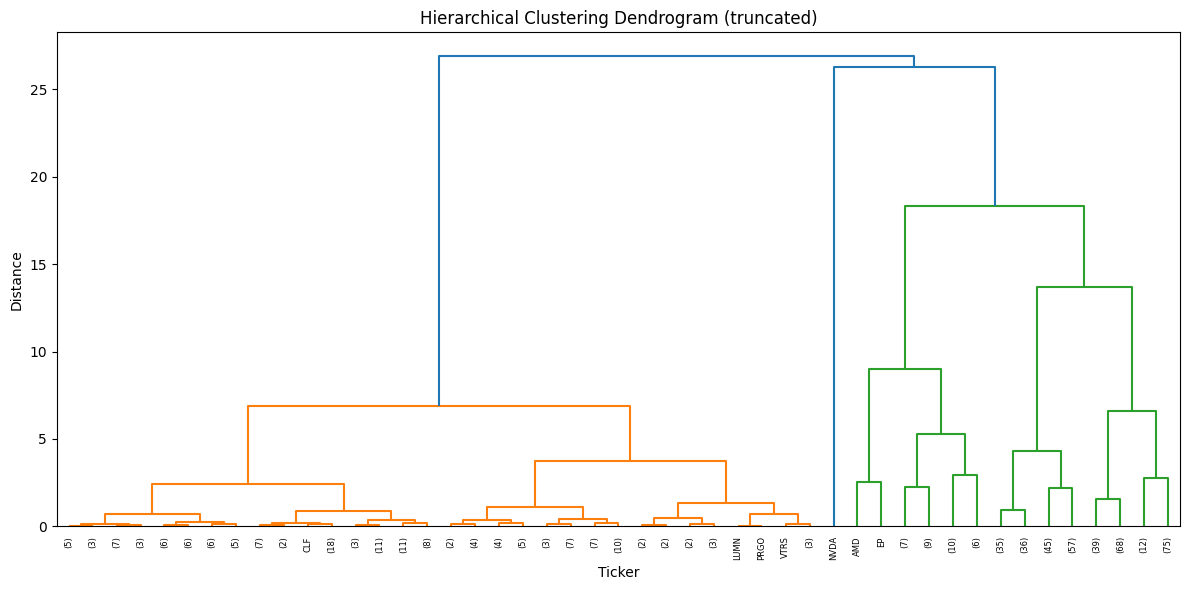

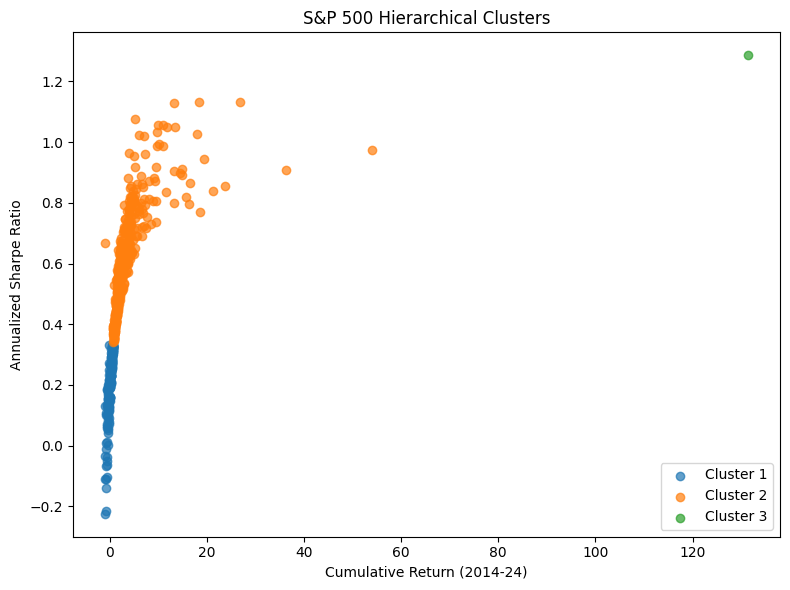


Cluster Summary:
         size        tickers_sample
cluster                            
1         159    AA,AAL,AAP,AIG,ALK
2         401  A,AAPL,ABBV,ABT,ACGL
3           1                  NVDA


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Silence yfinance logs
logging.getLogger("yfinance").setLevel(logging.CRITICAL)
logging.getLogger("urllib3").setLevel(logging.CRITICAL)

# 1. Load tickers
df_surv = pd.read_csv('sp500_current.csv')
sym_col = 'Symbol' if 'Symbol' in df_surv.columns else 'S y m b o l'
survivors = df_surv[sym_col].dropna().astype(str).str.replace('.', '-').str.replace('/', '-').tolist()

df_del = pd.read_csv(
    'sp500_delistings.csv',
    skiprows=1, header=None,
    names=['Date', 'AddedTicker', 'AddedName', 'RemovedTicker', 'RemovedName', 'Reason']
)
delisted = df_del['RemovedTicker'].dropna().astype(str).str.replace('.', '-').str.replace('/', '-').tolist()

all_tickers = survivors + delisted

# 2. Download price data (2014-2024)
prices = yf.download(all_tickers, start='2014-01-01', end='2024-01-01',
                     auto_adjust=True, progress=False)['Close']
prices = prices.dropna(axis=1, how='any')

# 3. Compute features
rets = prices.pct_change().dropna()
cumret = (1 + rets).prod() - 1
sharpe = rets.mean() / rets.std() * np.sqrt(252)

df_feat = pd.DataFrame({'cumret': cumret, 'sharpe': sharpe}).dropna()

# 4. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_feat)

# 5. Hierarchical clustering using Ward's method
Z = linkage(X_scaled, method='ward')

# 6. Plot dendrogram (truncated for readability)
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=df_feat.index, leaf_rotation=90, leaf_font_size=6,
           truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Ticker')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# 7. Assign clusters (e.g., 3 clusters)
clusters = fcluster(Z, t=3, criterion='maxclust')
df_feat['cluster'] = clusters

# 8. Scatter of clusters
plt.figure(figsize=(8, 6))
for c in np.unique(clusters):
    subset = df_feat[df_feat['cluster'] == c]
    plt.scatter(subset['cumret'], subset['sharpe'], label=f'Cluster {c}', alpha=0.7)
plt.xlabel('Cumulative Return (2014-24)')
plt.ylabel('Annualized Sharpe Ratio')
plt.title('S&P 500 Hierarchical Clusters')
plt.legend()
plt.tight_layout()
plt.show()

# 9. Display cluster sizes and sample tickers without deprecation warning
cluster_summary = df_feat['cluster'].value_counts().sort_index().to_frame('size')
# Build sample tickers manually to avoid groupby.apply warning
samples = {
    cluster: ','.join(df_feat[df_feat['cluster']==cluster].index[:5])
    for cluster in df_feat['cluster'].unique()
}
cluster_summary['tickers_sample'] = cluster_summary.index.map(samples)

print("\nCluster Summary:")
print(cluster_summary)


Cluster 1 (159 tickers): This mid-sized group contains firms like AA (Alcoa), AAL (American Airlines), AAP (Advance Auto Parts), AIG, ALK. These tend to be moderate performers—not the very best in cumulative return or Sharpe, but not the worst either.

Cluster 2 (401 tickers): The largest group includes A (Agilent), AAPL (Apple), ABBV (AbbVie), ABT (Abbott Labs), ACGL (Arch Capital), and so on. These are your higher-performing survivors with above-average returns and Sharpe ratios—most of today’s S&P 500 constituents fall here.

Cluster 3 (1 ticker): NVDA (NVIDIA) stands alone in its own cluster, indicating that its combination of exceptionally high cumulative return and Sharpe ratio from 2014–2024 is so distinct that it didn’t group with any other firm.

Cluster 2 (the large, high-performing group) corresponds almost entirely to the survivor class—those firms whose stellar returns and risk profiles kept them in the index.

Cluster 1 contains a mix of survivors and some firms that eventually delisted, showing more borderline performance.

Cluster 3 being a single, exceptional outlier (NVDA) highlights how looking only at survivors would disproportionately emphasize such outliers, inflating perceived “average” index performance.

#Business Data:

##Logistic Regression:

Accuracy: 1.00
ROC AUC : 1.00
Confusion Matrix (normalized):
[[1. 0.]
 [0. 1.]]


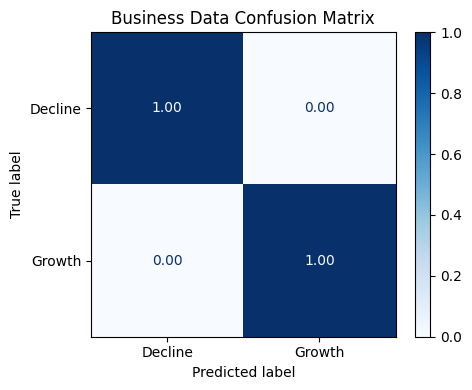

<Figure size 500x400 with 0 Axes>

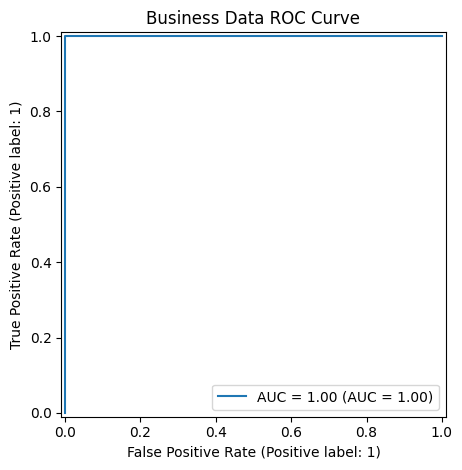

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, roc_auc_score,
                             RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix)

# 1. Load & prepare data
cols = ["Month","Year","NetChange","TotalEstab1","Expanding",
        "Opening","TotalEstab2","Contracting","Closing"]
df = pd.read_csv(
    'Business_data.txt', sep=r'\s+', engine='python',
    skiprows=3, names=cols, header=None
)
df['Positive'] = (df['NetChange'] > 0).astype(int)

X = df[['Expanding','Contracting','Opening','Closing']]
y = df['Positive']

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

# 3. Pipeline: scaling + logistic regression
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('logreg', LogisticRegression(class_weight='balanced', random_state=1))
])
pipe.fit(X_train, y_train)

# 4. Predictions & probabilities
y_pred  = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1]

# 5. Metrics
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred, normalize='true')

print(f"Accuracy: {acc:.2f}")
print(f"ROC AUC : {auc:.2f}")
print("Confusion Matrix (normalized):")
print(cm)

# 6. Plot confusion matrix
plt.figure(figsize=(5,4))
ConfusionMatrixDisplay(cm, display_labels=['Decline','Growth']) \
    .plot(cmap='Blues', values_format='.2f', ax=plt.gca())
plt.title('Business Data Confusion Matrix')
plt.tight_layout()
plt.show()

# 7. Plot ROC curve
plt.figure(figsize=(5,4))
RocCurveDisplay.from_predictions(y_test, y_proba, name=f"AUC = {auc:.2f}")
plt.title('Business Data ROC Curve')
plt.tight_layout()
plt.show()


A 100% accuracy and AUC of 1.00 means that on the 30% hold-out set, the logistic model made no mistakes—it perfectly separated “decline” years from “growth” years.

1. Trivial Separability:

Opening vs. Closing

Expanding vs. Contracting

are almost deterministically tied to whether NetChange is positive or negative. For example, if Opening – Closing and Expanding – Contracting are both strongly positive, then NetChange will also be positive. A linear boundary (logistic regression) can thus cleanly split the two classes with zero errors.

Including failures (decline years) is what makes this separation possible. If the model was trained only on growth years, it would trivially predict “growth” always and decline conditions would never be spotted.

The perfect scores simply reflect that—once failures are in the data, the patterns are crystal-clear. That’s exactly the lesson of survivorship bias: ignoring failures hides the true decision boundary.

